In [3]:
# 내 구글 드라이버에 연동
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

width: 720 pixels
height: 960 pixels
channels: 3


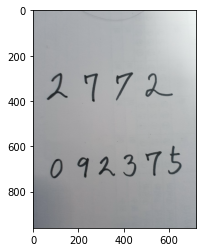

In [5]:
frame = 'gdrive/My Drive/CV/Digits Classify/ex/digit_test.jpg'

img = cv2.imread(frame)
#plt.figure(figsize=(10,10))
plt.imshow(img);
print("width: {} pixels".format(img.shape[1]))
print("height: {} pixels".format(img.shape[0]))
print("channels: {}".format(img.shape[2]))

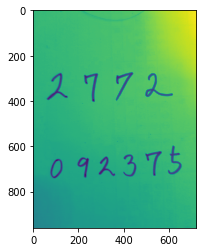

In [6]:
# hsv transform - value = gray image
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue, saturation, value = cv2.split(hsv)    # hue:색깔, saturation:채도(선명도), value:명도(밝기)
plt.imshow(value)

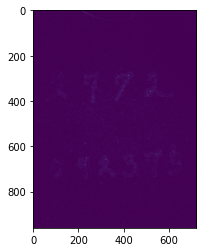

In [8]:
# kernel to use for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# applying topHat operations
topHat = cv2.morphologyEx(value, cv2.MORPH_TOPHAT, kernel)
plt.imshow(topHat)

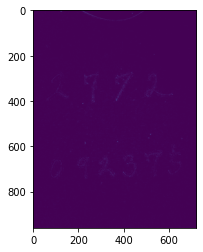

In [9]:
# applying blackHat operations
blackHat = cv2.morphologyEx(value, cv2.MORPH_BLACKHAT, kernel)
plt.imshow(blackHat)

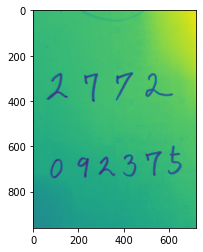

In [10]:
# add and subtract between morphological operations
add = cv2.add(value, topHat)
subtract = cv2.subtract(add, blackHat)
plt.imshow(subtract)

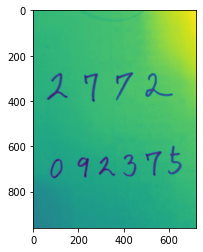

In [11]:
# applying median blur on subtract image
blur = cv2.medianBlur(subtract,5)
plt.imshow(blur)

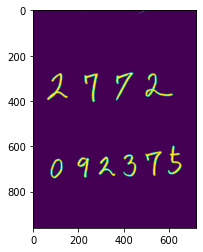

In [12]:
# thresholding
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 10)
plt.imshow(thresh)

In [13]:
# cv2.findCountours() function changed from OpenCV3 to OpenCV4: now it have only two parameters instead of 3
cv2MajorVersion = cv2.__version__.split(".")[0]
print('openCV version : ', cv2MajorVersion)
# check for contours on thresh
if int(cv2MajorVersion) >= 4:
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
else:
    imageContours, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

openCV version :  4


77 130 655 741
195 246 649 738
289 361 645 731
397 453 636 734
493 565 622 730
593 652 598 723
494 614 279 382
225 285 279 405
61 152 278 396
364 440 275 398


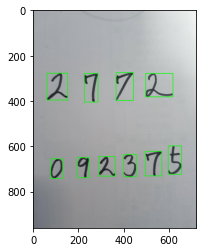

In [14]:
img_digits = []
img_origin = img.copy()
margin = 20

# loop to check if any (possible) contour is found
for contour in contours:
  x, y, w, h = cv2.boundingRect(contour)
  # Ignore if image is too small
  if w * h < 100: continue
  #Y and X [y-margin:y+h+margin, x-margin:x+w+margin]
  img_digits.append(thresh[y-margin:y+h+margin, x-margin:x+w+margin])  # 원본 이미지에서 박싱한 부분을 잘라서 img_digits 에 추가한다.
  cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
  print(x,  x+w, y, y+h)
plt.imshow(img)

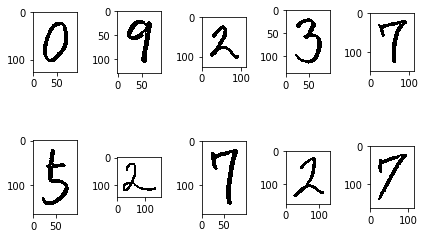

In [15]:
for i in range(0, len(img_digits)):
    plt.subplot(2, len(img_digits)/2, i+1)
    plt.imshow(img_digits[i], cmap='Greys', interpolation='nearest')
plt.tight_layout()
plt.show() 

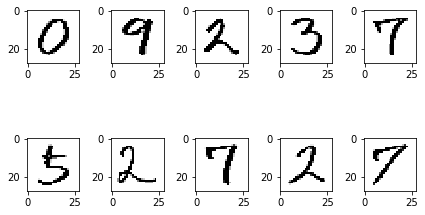

In [16]:
# 이미지 크기를 동일화
SZ = 28

for i in range(0, len(img_digits)):
    plt.subplot(2, len(img_digits)/2, i+1)
    plt.imshow(cv2.resize(img_digits[i], (SZ, SZ)), cmap='Greys', interpolation='nearest')
plt.tight_layout()  # 자동으로 레이아웃을 설정함
plt.show() 

In [18]:
# Load Deep Learning Model
import tensorflow as tf

model = tf.keras.models.load_model('gdrive/My Drive/CV/Digits Classify/ex/digits_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         131328    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 512)         5

[0.9999982, 3.6788288e-09, 6.1638593e-07, 5.4922706e-09, 2.2519974e-07, 9.848912e-08, 6.373449e-07, 4.34101e-08, 1.2805651e-07, 1.2124598e-07]
[1.9608988e-06, 5.4465827e-06, 5.3194135e-06, 2.2928412e-05, 0.0008591946, 1.2020901e-05, 1.3512941e-06, 0.00034869136, 5.782796e-05, 0.9986852]
[1.6978254e-06, 2.488754e-06, 0.99997914, 1.3199458e-06, 7.901467e-07, 3.4150858e-08, 2.6777648e-06, 1.0380564e-05, 1.5057818e-06, 4.989101e-08]
[1.6617038e-14, 9.734408e-12, 1.5797406e-10, 1.0, 2.4440248e-15, 3.2347551e-09, 4.429543e-15, 6.369583e-11, 1.9099093e-09, 2.1663409e-10]
[5.643309e-06, 0.01244293, 2.7533855e-05, 4.479431e-05, 0.00019794886, 4.5204974e-06, 1.6727374e-06, 0.98672336, 2.2251794e-05, 0.0005293906]
[3.642567e-08, 1.777868e-08, 5.4173017e-09, 3.249246e-05, 2.6002216e-09, 0.99996626, 1.8191555e-07, 2.6020177e-09, 3.3525828e-07, 6.681174e-07]
[1.0534884e-05, 0.0001366827, 0.9997156, 1.563277e-05, 7.4629957e-06, 9.1444326e-07, 2.3153581e-05, 7.4063486e-05, 1.535503e-05, 5.6822626e-07]

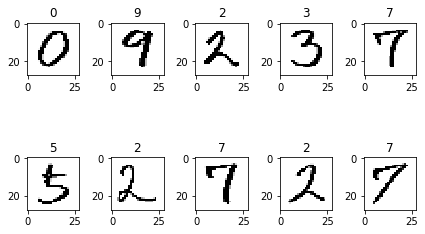

In [19]:
SZ = 28

for i in range(0, len(img_digits)):
    plt.subplot(2, len(img_digits)/2,i+1)
    num = cv2.resize(img_digits[i], (SZ,SZ))  # 이미지 크기를 동일화
    num = num.astype('float32') / 255.
    plt.imshow(num, cmap='Greys', interpolation='nearest');
    num = num.reshape(SZ, SZ, 1)
    result = model.predict(np.array([num]))
    result_number = np.argmax(result)
    plt.title(result_number)
    performance = [ val for val in result[0]]
    print(performance)
plt.tight_layout() # 자동으로 레이아웃을 설정함
plt.show()